In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

图像预处理

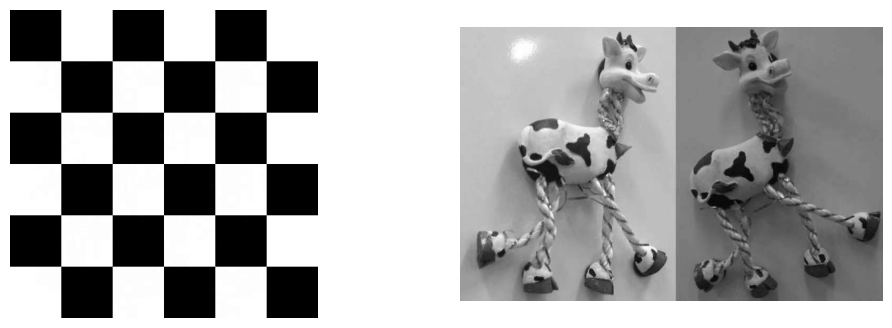

In [49]:
img = cv2.imread('image.png')
img2 = cv2.imread('image2.png')

def BGR2GRAY(img):
    gray = 0.299 * img[..., 2] + 0.587 * img[..., 1] + 0.114 * img[..., 0]
    gray = gray.astype(np.uint8)
    return gray

plt.figure(figsize=(12, 4))
gray = BGR2GRAY(img)
gray2 = BGR2GRAY(img2)
plt.subplot(1, 2, 1),plt.imshow(gray, cmap='gray'),plt.axis('off')
plt.subplot(1, 2, 2),plt.imshow(gray2, cmap='gray'),plt.axis('off')
plt.show()

梯度计算

In [50]:
def Sobel_filtering(gray):
    H, W = gray.shape

    sobely = np.array(((1, 2, 1),
                    (0, 0, 0),
                    (-1, -2, -1)), dtype=np.float32)

    sobelx = np.array(((1, 0, -1),
                    (2, 0, -2),
                    (1, 0, -1)), dtype=np.float32)

    tmp = np.pad(gray, (1, 1), 'edge')

    Ix = np.zeros_like(gray, dtype=np.float32)
    Iy = np.zeros_like(gray, dtype=np.float32)

    for y in range(H):
        for x in range(W):
            Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
            Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)

    return Ix, Iy

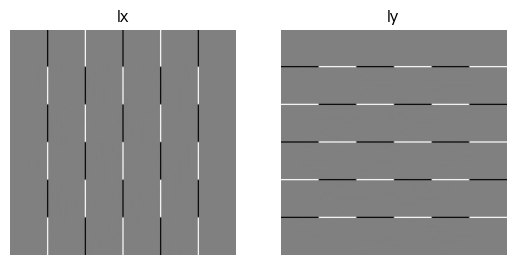

In [51]:
Ix, Iy = Sobel_filtering(gray)

plt.subplot(121), plt.imshow(Ix, cmap='gray'), plt.axis('off'), plt.title('Ix')
plt.subplot(122), plt.imshow(Iy, cmap='gray'), plt.axis('off'), plt.title('Iy')
plt.show()

二阶矩阵

In [53]:
def gaussian_filtering(I, K_size=3, sigma=3):
    H, W = I.shape

    I_t = np.pad(I, (K_size // 2, K_size // 2), 'edge')

    K = np.zeros((K_size, K_size), dtype=np.float32)
    for x in range(K_size):
        for y in range(K_size):
            _x = x - K_size // 2
            _y = y - K_size // 2
            K[y, x] = np.exp( -(_x ** 2 + _y ** 2) / (2 * (sigma ** 2)))
    K /= (sigma * np.sqrt(2 * np.pi))
    K /= K.sum()

    for y in range(H):
        for x in range(W):
            I[y,x] = np.sum(I_t[y : y + K_size, x : x + K_size] * K)
            
    return I

In [54]:
Ix2 = Ix ** 2
Iy2 = Iy ** 2
Ixy = Ix * Iy

Ix2 = gaussian_filtering(Ix2, K_size=3, sigma=3)
Iy2 = gaussian_filtering(Iy2, K_size=3, sigma=3)
Ixy = gaussian_filtering(Ixy, K_size=3, sigma=3)

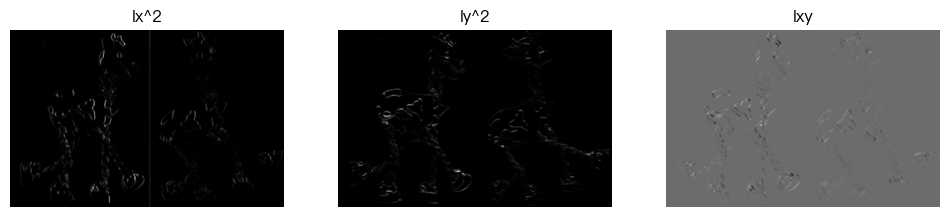

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(131), plt.imshow(Ix2, cmap='gray'), plt.axis('off'), plt.title('Ix^2')
plt.subplot(132), plt.imshow(Iy2, cmap='gray'), plt.axis('off'), plt.title('Iy^2')
plt.subplot(133), plt.imshow(Ixy, cmap='gray'), plt.axis('off'), plt.title('Ixy')
plt.show()

响应函数

In [56]:
def corner_detect(img, Ix2, Iy2, Ixy, th_ratio=0.1):
    H, W = img.shape
    # 计算Harris矩阵的特征值
    R = np.zeros_like(img, dtype=np.float32)
    for y in range(H):
        for x in range(W):
            M = np.array([[Ix2[y, x], Ixy[y, x]], [Ixy[y, x], Iy2[y, x]]], dtype=np.float32)
            det_M = np.linalg.det(M)
            trace_M = np.trace(M)
            if trace_M != 0:
                R[y, x] = det_M / trace_M

    R_th = (R > R.max() * th_ratio) + 0
    return R_th

非极大值抑制

In [57]:
def threshold_and_nms(R, th_ratio):
    R_th = (R > R.max() * th_ratio) + 0 # 阈值化处理
    R_dilate = dilate(R, kernel_size=(3, 3))    # 使用膨胀操作对角点响应图进行处理
    R_nms = R >= R_dilate   # 根据膨胀操作得到的结果进行非极大值抑制
    R_final = R_th * R_nms  # 最终的角点响应图

    return R_final


def dilate(R, kernel_size):
    R_dilate = np.zeros_like(R)     # 使用矩形结构元素进行膨胀操作
    H, W = R.shape
    kh, kw = kernel_size

    for y in range(H):
        for x in range(W):
            for ky in range(kh):
                for kx in range(kw):
                    ny = y + ky - kh // 2
                    nx = x + kx - kw // 2
                    if 0 <= ny < H and 0 <= nx < W:
                        R_dilate[y, x] = max(R_dilate[y, x], R[ny, nx])
    
    return R_dilate

描点

In [58]:
def DrawKeypoints(img, R_final):
    # 将图像转换为RGB格式（如果是灰度图的话）
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img.copy()

    # 找到角点的坐标
    corner_y, corner_x = np.where(R_final > 0)

    # 在图像上绘制角点
    plt.imshow(img_rgb)
    plt.scatter(corner_x, corner_y, c='r', s=0.2)  # 绘制红色的点作为角点
    plt.axis('off')
    plt.show()

final

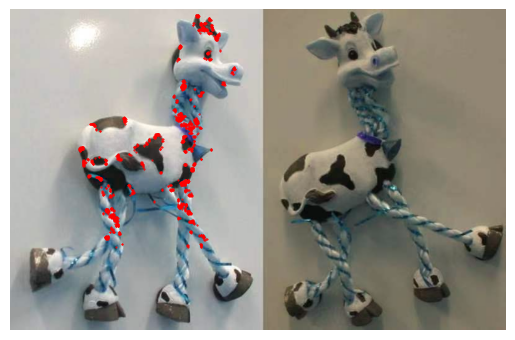

In [59]:
R = corner_detect(gray, Ix2, Iy2, Ixy, th_ratio=0.1)
result = img2.copy()
DrawKeypoints(result, R)

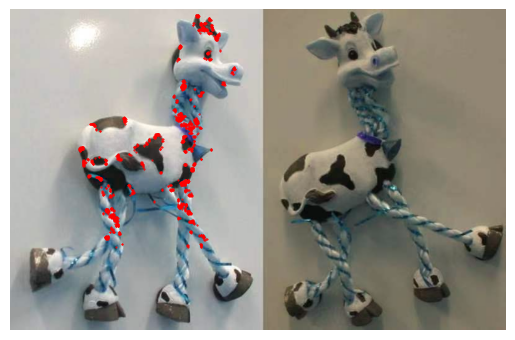

In [60]:
R = corner_detect(gray, Ix2, Iy2, Ixy, th_ratio=0.1)
R_final = threshold_and_nms(R, 0.05)

img2 = img.copy()
DrawKeypoints(result, R_final)